# Deep Learning practice

### Búsqueda y construcción del modelo de entrenamiento

In [1]:
import numpy as np
import pandas as pd

train = pd.read_csv('./train.csv',sep=';', decimal='.')
val = pd.read_csv('./val.csv',sep=';', decimal='.')
test = pd.read_csv('./test.csv',sep=';', decimal='.')

images = np.load('images.npy')
train_imgs = images[train['Unnamed: 0']]
val_imgs = images[val['Unnamed: 0']]
test_imgs = images[test['Unnamed: 0']]

Extraigo la variable objetivo y dropeo los índices para empezar a trabajar con los datos.

In [2]:
Y_train = train.Price
Y_val = val.Price
Y_test = test.Price

X_train = train.drop(columns=['Unnamed: 0','Price'])
X_val = val.drop(columns=['Unnamed: 0','Price'])
X_test = test.drop(columns=['Unnamed: 0','Price'])

Importo los paquetes necesarios

In [3]:
from keras.engine import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, concatenate
from keras.applications import VGG16
from keras.utils import to_categorical
import cv2

Using TensorFlow backend.


La siguiente función me permite simplificar la creación de un modelo denso. Se puede especificar el parámetro linear=True para que devuelva una arquitectura completa con una salida lineal.

In [4]:
def create_dense(dim, linear=False):
    model = Sequential()
    model.add(Dense(dim, input_dim=dim, activation='relu'))
    while dim > 18:
        dim //= 2
        model.add(Dense(dim, activation='relu'))
    
    if linear:
        model.add(Dense(3, activation='relu'))
        model.add(Dense(1, activation='linear'))
        
    return model

Echo un primer vistazo al modelo con los hiperparámetros que mejor suelen funcionar a nivel general.

In [6]:
atts_model = create_dense(X_train.shape[1], linear=True)

atts_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

atts_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=200, batch_size=1000)

Train on 6634 samples, validate on 738 samples
Epoch 1/200
6634/6634 [==============================] - 0s 28us/step - loss: 6420.9283 - mse: 6420.9287 - val_loss: 206409.2500 - val_mse: 206409.2500
Epoch 2/200
6634/6634 [==============================] - 0s 6us/step - loss: 5395.5341 - mse: 5395.5337 - val_loss: 781480.7500 - val_mse: 781480.7500
Epoch 3/200
6634/6634 [==============================] - 0s 7us/step - loss: 4433.7544 - mse: 4433.7539 - val_loss: 800081.6250 - val_mse: 800081.6250
Epoch 4/200
6634/6634 [==============================] - 0s 6us/step - loss: 3529.2403 - mse: 3529.2405 - val_loss: 335655.1562 - val_mse: 335655.1562
Epoch 5/200
6634/6634 [==============================] - 0s 6us/step - loss: 3034.0165 - mse: 3034.0164 - val_loss: 130231.8672 - val_mse: 130231.8672
Epoch 6/200
6634/6634 [==============================] - 0s 7us/step - loss: 2852.5383 - mse: 2852.5381 - val_loss: 29764.6152 - val_mse: 29764.6152
Epoch 7/200
6634/6634 [=========================

6634/6634 [==============================] - 0s 6us/step - loss: 1041.2217 - mse: 1041.2217 - val_loss: 1419.1627 - val_mse: 1419.1627
Epoch 111/200
6634/6634 [==============================] - 0s 6us/step - loss: 1052.7743 - mse: 1052.7743 - val_loss: 1453.8441 - val_mse: 1453.8441
Epoch 112/200
6634/6634 [==============================] - 0s 6us/step - loss: 1030.7021 - mse: 1030.7020 - val_loss: 1464.2418 - val_mse: 1464.2418
Epoch 113/200
6634/6634 [==============================] - 0s 6us/step - loss: 1030.7375 - mse: 1030.7375 - val_loss: 1420.2151 - val_mse: 1420.2151
Epoch 114/200
6634/6634 [==============================] - 0s 6us/step - loss: 1016.6117 - mse: 1016.6118 - val_loss: 1442.1294 - val_mse: 1442.1294
Epoch 115/200
6634/6634 [==============================] - 0s 6us/step - loss: 1028.3671 - mse: 1028.3671 - val_loss: 1433.6019 - val_mse: 1433.6019
Epoch 116/200
6634/6634 [==============================] - 0s 6us/step - loss: 1032.7574 - mse: 1032.7573 - val_loss: 17

In [7]:
print(f'MSE en test: {np.mean(((atts_model.predict(X_test) - Y_test.to_numpy().reshape(-1,1))**2).mean(axis=1))}')

MSE en test: 1183.4383611515207


No es excesivamente malo para ser un modelo tan simple. Ahora voy a definir un modelo para trabajar con las imágenes.

La siguiente función simplifica la creación de una arquitectura CNN. Su utilidad es parecida a la anterior, pero ésta me da la opción de utilizar una arquitectura base y hacer transfer learning.

In [5]:
def create_cnn(shape, base=None, linear=False, density=144, mode='trainable', dropout=None):
    
    if base:
        
        if mode == 'transfer_learning':
            for layer in base.layers: 
                layer.trainable = False
                
        if mode == 'keep_first':
            base.layers[1].trainable = False
        
        model = base.layers[-1].output
        model = Flatten()(model)
        model = Dense(density, activation='relu')(model)
        
        if linear:
            model = Dense(9, activation='relu')(model)
            model = Dense(3, activation='relu')(model)
            model = Dense(1, activation='linear')(model)
            
        model = Model(base.input, model)
    
    else:
        model = Sequential()
        
        model.add(Conv2D(18, kernel_size=(3, 3), input_shape=shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
    
        model.add(Conv2D(36, kernel_size=(3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        if dropout: model.add(Dropout(dropout))
    
        model.add(Conv2D(72, kernel_size=(3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        if dropout: model.add(Dropout(dropout))
    
        model.add(Conv2D(72, kernel_size=(3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    
        model.add(Flatten())
        model.add(Dense(density, activation='relu'))
    
        if linear:
            model.add(Dense(9, activation='relu'))
            model.add(Dense(3, activation='relu'))
            model.add(Dense(1, activation='linear'))
        
    return model

Reescalo las imágenes a la mitad de su resolución original por cuestiones de memoria RAM de mi GPU y después estandarizo los datos para que el modelo trabaje con números entre 0 y 1

In [26]:
shapes = []

for shape in (train_imgs.shape, val_imgs.shape, test_imgs.shape):
    shapes.append((shape[0],shape[1]//2,shape[2]//2,shape[3]))
    
train_imgs_res = np.zeros(shapes[0], dtype=int)
val_imgs_res = np.zeros(shapes[1], dtype=int)
test_imgs_res = np.zeros(shapes[2], dtype=int)        

for idx, img in zip(range(shapes[0][0]),train_imgs):
    train_imgs_res[idx] = cv2.resize(img, shapes[0][1:-1])

for idx, img in zip(range(shapes[1][0]),val_imgs):
    val_imgs_res[idx] = cv2.resize(img, shapes[1][1:-1])

for idx, img in zip(range(shapes[2][0]),test_imgs):
    test_imgs_res[idx] = cv2.resize(img, shapes[2][1:-1])
    
train_imgs_res = train_imgs_res / 255
val_imgs_res = val_imgs_res / 255
test_imgs_res = test_imgs_res / 255

Veamos cómo se comporta esta arquitectura

In [19]:
imgs_model = create_cnn(train_imgs_res.shape[1:], linear=True, dropout=0.2, density=512)

imgs_model.compile(loss='mse', optimizer='adam' , metrics=['mse'])

imgs_model.fit(train_imgs_res, Y_train, validation_data=(val_imgs_res, Y_val), epochs=5, batch_size=100)

Train on 6634 samples, validate on 738 samples
Epoch 1/5
6634/6634 [==============================] - 14s 2ms/step - loss: 3373.5612 - mse: 3373.5618 - val_loss: 5006.2853 - val_mse: 5006.2856
Epoch 2/5
6634/6634 [==============================] - 13s 2ms/step - loss: 3028.9497 - mse: 3028.9500 - val_loss: 4488.7453 - val_mse: 4488.7451
Epoch 3/5
6634/6634 [==============================] - 13s 2ms/step - loss: 2996.3681 - mse: 2996.3684 - val_loss: 3798.2024 - val_mse: 3798.2021
Epoch 4/5
6634/6634 [==============================] - 13s 2ms/step - loss: 2968.4253 - mse: 2968.4253 - val_loss: 3668.8245 - val_mse: 3668.8245
Epoch 5/5
6634/6634 [==============================] - 13s 2ms/step - loss: 2945.8788 - mse: 2945.8789 - val_loss: 3577.7160 - val_mse: 3577.7166


In [20]:
print(f'MSE en test: {np.mean(((imgs_model.predict(test_imgs_res) - Y_test.to_numpy().reshape(-1,1))**2).mean(axis=1))}')

MSE en test: 3116.577766626536


Ahora voy a probar con VGG16 cargando los pesos de imagenet.

In [6]:
shapes = []

for shape in (train_imgs.shape, val_imgs.shape, test_imgs.shape):
    shapes.append((shape[0],48,48,3)) # Reescalo a 48, 48, 3 para poder usar VGG16
    
train_imgs_res = np.zeros(shapes[0], dtype=int)
val_imgs_res = np.zeros(shapes[1], dtype=int)
test_imgs_res = np.zeros(shapes[2], dtype=int)        

for idx, img in zip(range(shapes[0][0]),train_imgs):
    train_imgs_res[idx] = cv2.resize(img, shapes[0][1:-1])

for idx, img in zip(range(shapes[1][0]),val_imgs):
    val_imgs_res[idx] = cv2.resize(img, shapes[1][1:-1])

for idx, img in zip(range(shapes[2][0]),test_imgs):
    test_imgs_res[idx] = cv2.resize(img, shapes[2][1:-1])
    
train_imgs_res = train_imgs_res / 255
val_imgs_res = val_imgs_res / 255
test_imgs_res = test_imgs_res / 255

In [22]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=train_imgs_res.shape[1:])

vgg16_model = create_cnn(train_imgs_res.shape[1:], base=vgg16_model, linear=True, density=1024, mode='transfer_learning')

vgg16_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

vgg16_model.fit(train_imgs_res, Y_train, validation_data=(val_imgs_res, Y_val), epochs=5, batch_size=100)

Train on 6634 samples, validate on 738 samples
Epoch 1/5
6634/6634 [==============================] - 7s 1ms/step - loss: 4287.6449 - mse: 4287.6450 - val_loss: 3664.3528 - val_mse: 3664.3530
Epoch 2/5
6634/6634 [==============================] - 5s 792us/step - loss: 3035.5118 - mse: 3035.5120 - val_loss: 3636.4545 - val_mse: 3636.4546
Epoch 3/5
6634/6634 [==============================] - 5s 792us/step - loss: 3012.9005 - mse: 3012.8999 - val_loss: 3634.9739 - val_mse: 3634.9739
Epoch 4/5
6634/6634 [==============================] - 5s 794us/step - loss: 3008.0693 - mse: 3008.0691 - val_loss: 3615.7102 - val_mse: 3615.7100
Epoch 5/5
6634/6634 [==============================] - 5s 795us/step - loss: 2992.9559 - mse: 2992.9556 - val_loss: 3636.4518 - val_mse: 3636.4517


In [23]:
print(f'MSE en test: {np.mean(((vgg16_model.predict(test_imgs_res) - Y_test.to_numpy().reshape(-1,1))**2).mean(axis=1))}')

MSE en test: 3092.6069059289584


Hasta aquí he definido dos funciones que permiten generar mis modelos de una forma sencilla. Ahora toca unificarlos.

Primero voy a pasar la variable objetivo a categórica para trabajar con las categorías "barato", "asequible" y "caro", ya que seguramente serán más fáciles de predecir que un precio aproximado.

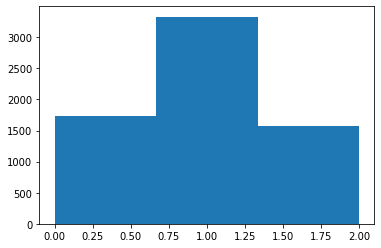

In [7]:
import matplotlib.pyplot as plt

Y_train_cat = []
for y in Y_train:
    if y < 35: Y_train_cat.append(0)
    elif y < 85: Y_train_cat.append(1)
    else: Y_train_cat.append(2)
        
plt.hist(Y_train_cat, bins=3)
plt.show()

In [8]:
Y_val_cat = []
for y in Y_val:
    if y < 35: Y_val_cat.append(0)
    elif y < 85: Y_val_cat.append(1)
    else: Y_val_cat.append(2)
        
Y_test_cat = []
for y in Y_test:
    if y < 35: Y_test_cat.append(0)
    elif y < 85: Y_test_cat.append(1)
    else: Y_test_cat.append(2)

Ahora que tenemos un buen reparto de los valores en categorías, veamos como se comportan nuestros modelos si los unificamos. Comienzo creando mis dos modelos (atributos e imágenes) con las funciones que definí al comienzo del notebook, pero esta vez le indicaré en los parámetros que no quiero un final lineal. Así podré combinarlas y agregar las capas finales que crea convenientes.

(he dejado comentados algunos de los modelos que he estado probando)

In [29]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=train_imgs_res.shape[1:])

#imgs_model = create_cnn(train_imgs_res.shape[1:], base=vgg16_model, linear=False, density=512, mode='transfer_learning')
#imgs_model = create_cnn(train_imgs_res.shape[1:], linear=False, density=512)
#imgs_model = create_cnn(train_imgs_res.shape[1:], base=vgg16_model, linear=False, density=512)
imgs_model = create_cnn(train_imgs_res.shape[1:], base=vgg16_model, linear=False, density=512, mode='keep_first')

atts_model = create_dense(X_train.shape[1], linear=False)

combined = concatenate([atts_model.output, imgs_model.output])

# Añado una nueva capa de procesado y una última salida que me haga la clasificación.
z = Dense(9, activation='relu')(combined)
z = Dense(3, activation='softmax')(z)

combined_model = Model([atts_model.input, imgs_model.input], z)

combined_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

combined_model.fit([X_train, train_imgs_res], Y_train_cat, validation_data=([X_val, val_imgs_res], Y_val_cat),
             epochs=100, batch_size=100)

Train on 6634 samples, validate on 738 samples
Epoch 1/100
6634/6634 [==============================] - 15s 2ms/step - loss: 1.3015 - accuracy: 0.4806 - val_loss: 1.1531 - val_accuracy: 0.5447
Epoch 2/100
6634/6634 [==============================] - 15s 2ms/step - loss: 1.0077 - accuracy: 0.5232 - val_loss: 2.4443 - val_accuracy: 0.5569
Epoch 3/100
6634/6634 [==============================] - 15s 2ms/step - loss: 0.9512 - accuracy: 0.5505 - val_loss: 1.0223 - val_accuracy: 0.5786
Epoch 4/100
6634/6634 [==============================] - 15s 2ms/step - loss: 0.9013 - accuracy: 0.5787 - val_loss: 1.4915 - val_accuracy: 0.5786
Epoch 5/100
6634/6634 [==============================] - 15s 2ms/step - loss: 0.9147 - accuracy: 0.5725 - val_loss: 3.1949 - val_accuracy: 0.5515
Epoch 6/100
6634/6634 [==============================] - 15s 2ms/step - loss: 0.8720 - accuracy: 0.5927 - val_loss: 2.5732 - val_accuracy: 0.5949
Epoch 7/100
6634/6634 [==============================] - 15s 2ms/step - loss:

In [30]:
print(f'Accuracy in test: {sum(np.array([np.argmax(comb) for comb in combined_model.predict([X_test,test_imgs_res])])==np.array(Y_test_cat))/len(Y_test)}')

Accuracy in test: 0.7434924078091106


A ver ahora cómo se comportaría esta misma arquitectura frente a un problema de regresión añadiendo una capa más de complejidad

In [13]:
# Añado una salida que me haga la regresión.
z = Dense(256, activation='relu')(combined)
z = Dense(128, activation='relu')(z)
z = Dense(8, activation='relu')(z)
z = Dense(1, activation='linear')(z)

combined_model = Model([atts_model.input, imgs_model.input], z)

combined_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

combined_model.fit([X_train, train_imgs_res], Y_train, validation_data=([X_val, val_imgs_res], Y_val),
             epochs=100, batch_size=100)

Train on 6634 samples, validate on 738 samples
Epoch 1/100
6634/6634 [==============================] - 15s 2ms/step - loss: 1472.8067 - mse: 1472.8064 - val_loss: 1705.0753 - val_mse: 1705.0752
Epoch 2/100
6634/6634 [==============================] - 15s 2ms/step - loss: 900.1619 - mse: 900.1620 - val_loss: 1356.5290 - val_mse: 1356.5289
Epoch 3/100
6634/6634 [==============================] - 15s 2ms/step - loss: 826.6339 - mse: 826.6337 - val_loss: 1361.7367 - val_mse: 1361.7366
Epoch 4/100
6634/6634 [==============================] - 15s 2ms/step - loss: 833.5047 - mse: 833.5048 - val_loss: 1397.0136 - val_mse: 1397.0135
Epoch 5/100
6634/6634 [==============================] - 15s 2ms/step - loss: 758.1603 - mse: 758.1604 - val_loss: 1350.3175 - val_mse: 1350.3175
Epoch 6/100
6634/6634 [==============================] - 15s 2ms/step - loss: 804.8815 - mse: 804.8813 - val_loss: 1369.9769 - val_mse: 1369.9768
Epoch 7/100
6634/6634 [==============================] - 15s 2ms/step - los

6634/6634 [==============================] - 15s 2ms/step - loss: 640.4487 - mse: 640.4485 - val_loss: 1443.2459 - val_mse: 1443.2460
Epoch 57/100
6634/6634 [==============================] - 15s 2ms/step - loss: 629.9518 - mse: 629.9519 - val_loss: 1374.6974 - val_mse: 1374.6975
Epoch 58/100
6634/6634 [==============================] - 15s 2ms/step - loss: 622.7304 - mse: 622.7305 - val_loss: 1396.4719 - val_mse: 1396.4719
Epoch 59/100
6634/6634 [==============================] - 15s 2ms/step - loss: 680.5748 - mse: 680.5748 - val_loss: 1359.9280 - val_mse: 1359.9280
Epoch 60/100
6634/6634 [==============================] - 15s 2ms/step - loss: 654.7211 - mse: 654.7212 - val_loss: 1345.9263 - val_mse: 1345.9263
Epoch 61/100
6634/6634 [==============================] - 15s 2ms/step - loss: 618.0529 - mse: 618.0529 - val_loss: 1468.2623 - val_mse: 1468.2623
Epoch 62/100
6634/6634 [==============================] - 14s 2ms/step - loss: 772.3636 - mse: 772.3635 - val_loss: 1341.7193 - val

In [14]:
print(f'MSE en test: {np.mean(((combined_model.predict([X_test, test_imgs_res]) - Y_test.to_numpy().reshape(-1,1))**2).mean(axis=1))}')

MSE en test: 1184.428657944656
